In [8]:
import yfinance as yf
import pandas as pd
from datetime import date, timedelta, datetime

vix = yf.download('^VIX', start='2010-01-31', end='2022-12-06', interval='1d', prepost=False, threads=True)['Close']
nvda = yf.download('NVDA', start='2010-01-31', end='2022-12-06', interval='1d', prepost=False, threads=True)['Close']
sp500 = yf.download('^GSPC', start='2010-01-31', end='2022-12-06', interval='1d', prepost=False, threads=True)['Close']
sp500 = sp500.resample('1Y').last().pct_change().dropna().mean()
nvidia_beta = yf.Ticker('NVDA').info['beta']
rf = yf.download('^TNX', start='2010-01-31', end='2022-12-06', interval='1d', prepost=False, threads=True)['Close'] / 100

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Nvidia earnings are always released after market close, so we take the closing price of that day
NVDA_file_dates = [date(2010, 2, 17), date(2011, 2, 16), date(2012, 2, 15), date(2013, 2, 13), date(2014, 2, 12), date(2015, 2, 11), date(2016, 2, 17), date(2017, 2, 9), date(2018, 2, 8), date(2019, 2, 14), date(2020, 2, 13), date(2021, 2, 24), date(2022, 2, 16), date(2022, 12, 5)]
NVDA_file_dates = list(map(pd.to_datetime, NVDA_file_dates))

In [ ]:
def yearly_returns_FY(df, FYs):
    df = df[df.index.isin(FYs)]
    df = df.pct_change()
    return df.dropna()

def yearly_slice(df, FYs):
    df = df[df.index.isin(FYs)]
    return df.dropna()

def ewma(df, d=0.94):
    return df.pct_change().ewm(alpha=1-d, adjust=True).mean()

def capm(beta, sp500, rf):
    return beta * (sp500 - rf) + rf

# Ground truths
nvda_yearly_closes = nvda[nvda.index.isin(NVDA_file_dates)]
nvda_yearly_returns = yearly_returns_FY(nvda, NVDA_file_dates)
vix_yearly_mean = vix.groupby(pd.Grouper(freq='1Y')).mean()

# Features
nvda_yearly_ewma_returns = yearly_slice(ewma(nvda, d=0.99), NVDA_file_dates) * 252.03  # assuming 1 year 252.03 trading days (on avg), since ewma is daily so return needs to be annualized
nvidia_capm = yearly_slice(capm(nvidia_beta, sp500, rf), NVDA_file_dates)

In [ ]:
# Align features, start 2012-02-15
# for CAPM and EWMA, value at 2012 feb will predict return from 2012 feb to 2013 feb
nvidia_capm = nvidia_capm[2:]
nvda_yearly_ewma_returns = nvda_yearly_ewma_returns[2:]

# Predicting returns 1 year ahead so yearly_returns should start with return from 2012 feb to 2013 feb, which is the value at 2013 feb
nvda_yearly_returns = nvda_yearly_returns[2:]
# for dcf and comps, FY 2012 implied price should predict the price on 2013 feb (end of FY 2013), so the implied upside is calculated from 2012 feb.
DCF = [10.03, 12.88, 23.93, 27.76, 39.93, 44.23, 65.58, 70.36, 88.41, 110.16, 132.15, 132.15]
nvda_yearly_closes = nvda_yearly_closes[2:]
DCF_implied_upside = (DCF / nvda_yearly_closes) - 1

Comps = [1.901528662, 4.384016227, 4.45896, 3.697478992, 4.707282416, 4.532161687, 19.31687211, 37.84643987, 19.0486, 29.0684466, 53.67537849, 104.2521499, 104.2521499]
Comps = Comps[1:]  # align comps
Comps_implied_upside = (Comps / nvda_yearly_closes) - 1

# Align VIX
vix_yearly_mean = vix_yearly_mean[2:]
vix_yearly_mean = vix_yearly_mean.append(pd.Series(vix_yearly_mean.iloc[-1], index=[pd.to_datetime('2022-12-31')]))  # duplicate last value
assert len(nvidia_capm) == len(nvda_yearly_ewma_returns) == len(DCF) == len(Comps) == len(vix_yearly_mean) == len(nvda_yearly_returns) + 1

In [ ]:
import matplotlib.pyplot as plt
nvda_yearly_returns.plot()
nvda_yearly_ewma_returns.plot()
nvidia_capm.plot()
DCF_implied_upside.plot()
Comps_implied_upside.plot()
plt.legend(['Actual Returns', 'EWMA Returns', 'CAPM', 'DCF', 'Comps'])

In [ ]:
# Preparing dataset for ML
features = pd.DataFrame({'EWMA': nvda_yearly_ewma_returns.values, 'CAPM': nvidia_capm.values, 'DCF': DCF_implied_upside.values, 'Comps':  Comps_implied_upside.values, 'VIX': vix_yearly_mean.values}, index=nvda_yearly_ewma_returns.index)
pred_inputs = features[-1:]  # data at 2022 dec, use to predict return of nvidia in 2023 feb
features = features[:-1]  # remove last row as it is used for prediction only (no ground truth for this)
target = nvda_yearly_returns

In [ ]:
# ML
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.models.experimental import SharpnessAwareMinimization
from tensorflow.keras.utils import plot_model
import gc

In [ ]:
tf.keras.backend.clear_session()  # reset model and layer names
xIn = Input(shape=(5,))
x = Dense(64, activation='swish')(xIn)
x = LayerNormalization()(x)
reg_x = Dense(4, name='regression_layer', activation='linear')(xIn[:, :4])
reg_x = LayerNormalization()(reg_x)
x = Concatenate()([reg_x, x])
x = Dense(64, activation='swish')(x)
x = LayerNormalization()(x)
xOut = Dense(1)(x)

model = Model(inputs=xIn, outputs=xOut)
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
model = SharpnessAwareMinimization(model)  # this give higher loss but better generalization but for the sake of the competition we should go for lower loss
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='mse', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
epoch = 100000
callbacks = [
    LearningRateScheduler(CosineDecay(1e-3, epoch)),  # using epoch=step here as batchsize=sample size
    EarlyStopping(monitor='loss', patience=3000, restore_best_weights=True),
    ReduceLROnPlateau(monitor='loss', factor=0.5, patience=1000, min_lr=1e-7)
]
hist = model.fit(features, target, epochs=epoch, batch_size=len(target), verbose=0, callbacks=callbacks, use_multiprocessing=True, shuffle=True)
print(hist.epoch[-1], min(hist.history['root_mean_squared_error']))  # show final epoch no and  lowest rmse
gc.collect()

In [ ]:
# wtih regression branch 64 64: 10574 9.388914179453423e-08
# wtih regression branch 64 64 no weight decay: 13867 5.595381225020901e-08
# wtih regression branch 64 64 no weight decay layer norm : 10938 4.544243381587876e-08
# NEW DATA wtih regression branch 64 64 no weight decay layer norm : 13774 5.8923426138335344e-08
# Above all with cosine decay

# wtih regression branch 64 64 no weight decay layer norm, cosine decay restarts: 11078 6.861009893555092e-08
# wtih regression branch 64 64 no weight decay layer norm, ExponentialDecay rate=0.96: 10707 7.670841739582102e-08
# wtih regression branch 64 64 no weight decay layer norm, InverseTimeDecay rate=0.96: 5493 4.297550185583532e-05
# wtih regression branch 64 64 no weight decay layer norm, PolynomialDecay: 9599 5.1619135632563484e-08 (patience=5000, reducelr=2000: 18073 4.664801167564292e-08)

# wtih regression branch 64 128 no weight decay: 13184 6.197880253466792e-08
# wtih regression branch 32 64: 12128 6.339563896062828e-08
# without regression branch 32 64: 18573 1.3236056872756308e-07
# without regression branch 64 64: 11513 2.802448477723374e-07

In [ ]:
model.save('SAM 19906 0.0003908690414391458')

In [ ]:
plt.plot(hist.history['root_mean_squared_error'])

In [ ]:
# Not using
import autokeras as ak
import keras_tuner as kt
reg = ak.StructuredDataRegressor(column_types={feat: 'numerical' for feat in features.columns}, overwrite=True, max_trials=100, loss="mean_squared_error", metrics=[tf.keras.metrics.RootMeanSquaredError()], objective=kt.Objective("root_mean_squared_error", direction='min'))
hist = reg.fit(features, target, epochs=10000, batch_size=len(target)//2, verbose=0, use_multiprocessing=True, shuffle=True, validation_split=0.0000000001)
model = reg.export_model()
model.summary()

In [ ]:
model = tf.keras.models.load_model('new data 13774 5.8923426138335344e-08')
model.summary()

In [ ]:
print(0.0003908690414391458*100, '%', sep='')  # RMSE on returns %
# Overridding prediction inputs
# NVDA_file_dates = [date(2010, 2, 17), date(2011, 2, 16), date(2012, 2, 15), date(2013, 2, 13), date(2014, 2, 12), date(2015, 2, 11), date(2016, 2, 17), date(2017, 2, 9), date(2018, 2, 8), date(2019, 2, 14), date(2020, 2, 13), date(2021, 2, 24), date(2022, 2, 16), date(2022, 12, 5)]
# NVDA_file_dates = list(map(pd.to_datetime, NVDA_file_dates))
# nvda_yearly_ewma_returns = yearly_slice(ewma(nvda, d=0.99), NVDA_file_dates) * 252.03  # assuming 1 year 252.03 trading days (on avg), since ewma is daily so return needs to be annualized
# pred_inputs['EWMA'] = nvda_yearly_ewma_returns[-1]  # override EWMA to the value at 23 Nov 2022
# pred_inputs['CAPM'] = 0.16478
# pred_inputs['DCF'] = -0.22877
# pred_inputs['Comps'] = -0.29484
pred_inputs = features[-1:]
pred_inputs_today = pred_inputs.copy()
model.predict(pred_inputs)

In [ ]:
hist_preds = model.predict(features)
hist_preds = pd.Series(hist_preds.flatten(), index=target.index)
plt.plot(hist_preds)
plt.plot(target)
plt.legend(['Predicted', 'Actual'])

In [ ]:
hist_preds

In [ ]:
# Plotting relationships
# pred_inputs['EWMA'] = 0.19366
# pred_inputs['CAPM'] = 0.16478
# pred_inputs['DCF'] = -0.22877
# pred_inputs['Comps'] = -0.29484
# pred_inputs['VIX'] = 25.94792
pred = model.predict(pred_inputs)[0][0]

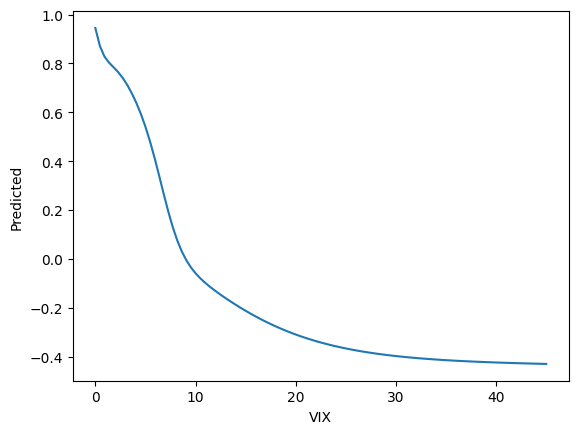

In [76]:
preds = []
# pred_inputs['EWMA'] = 0.19366
# pred_inputs['CAPM'] = 0.16478
# pred_inputs['DCF'] = -0.22877
# pred_inputs['Comps'] = -0.29484
# pred_inputs['VIX'] = 25.94792
pred_inputs = features[-1:].copy()
for VIX in VIX_range:
    pred_inputs['VIX'] = VIX
    pred = model.predict(pred_inputs, verbose=0)[0][0]
    preds.append(pred)
plt.xlabel('VIX')
plt.ylabel('Predicted')
plt.plot(VIX_range, preds)